REQUIREMENTS:
  - PYTHON (default packages)
  - NIBABEL (for neuroimaging)
  - PYTORCH (for deep learning)

In [1]:
'''
IMPORTS
'''
import numpy as np
import os
import argparse
import torch
import torch.optim as optim
import datetime
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats
import math

import cv2
import torch as tc
import nibabel as nib

from model import ModelWrapper
from utils import DeficitDataset, resize
import random
from scipy.stats import norm

/home/gp/anaconda3/lib/python3.7/site-packages/pandas/compat/_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


LOAD IN THE DATA -- FOR YOUR CUSTOM CASE YOU WOULD NEED TO WRITE YOUR OWN LOADERS

In [2]:
# LOAD THE EXAMPLE LESIONS
lesions = np.load('data/1500_lesions.npy')

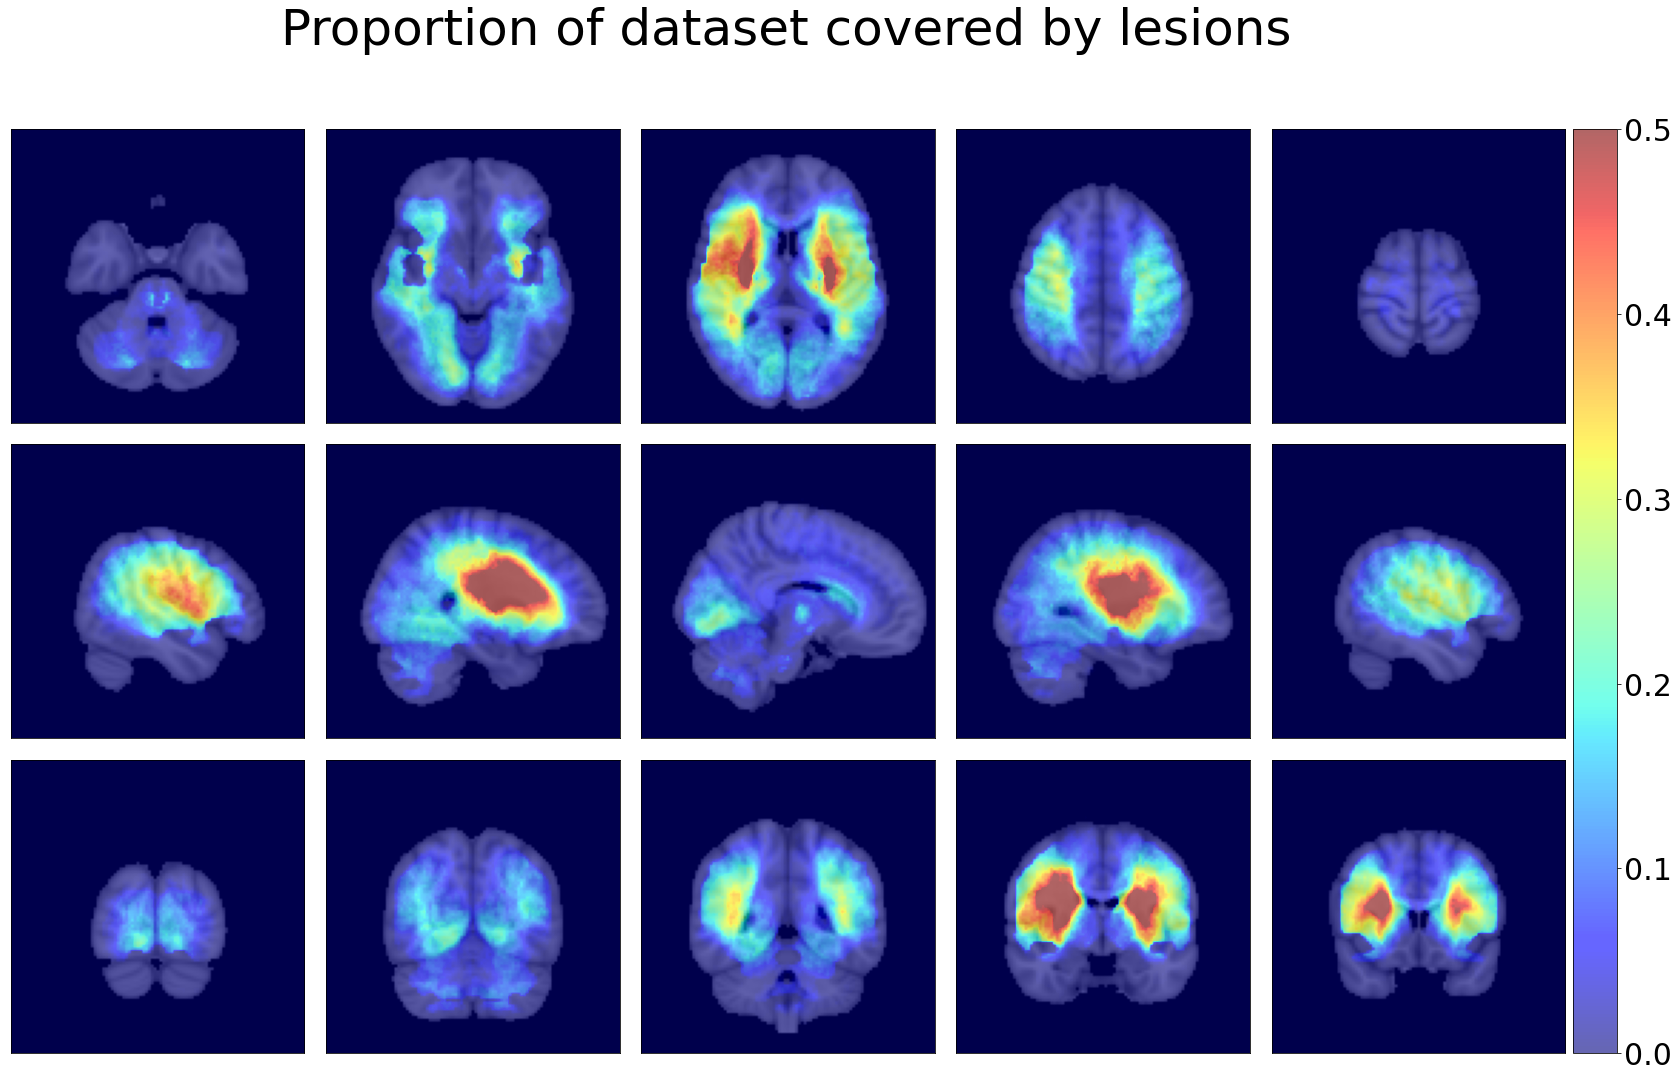

In [3]:
from IPython.display import Image

# HERE WE SHOWCASE OUR LESION DISTRIBUTION

dist_path = 'imgs/lesion_dataset_proportions.png'
Image(filename=dist_path, width=1000, height=100)

NORMALLY YOU'D LOAD IN YOUR OWN FUNCTIONAL DEFICITS, BUT HERE WE SIMULATE THEM 

(32, 32, 32)


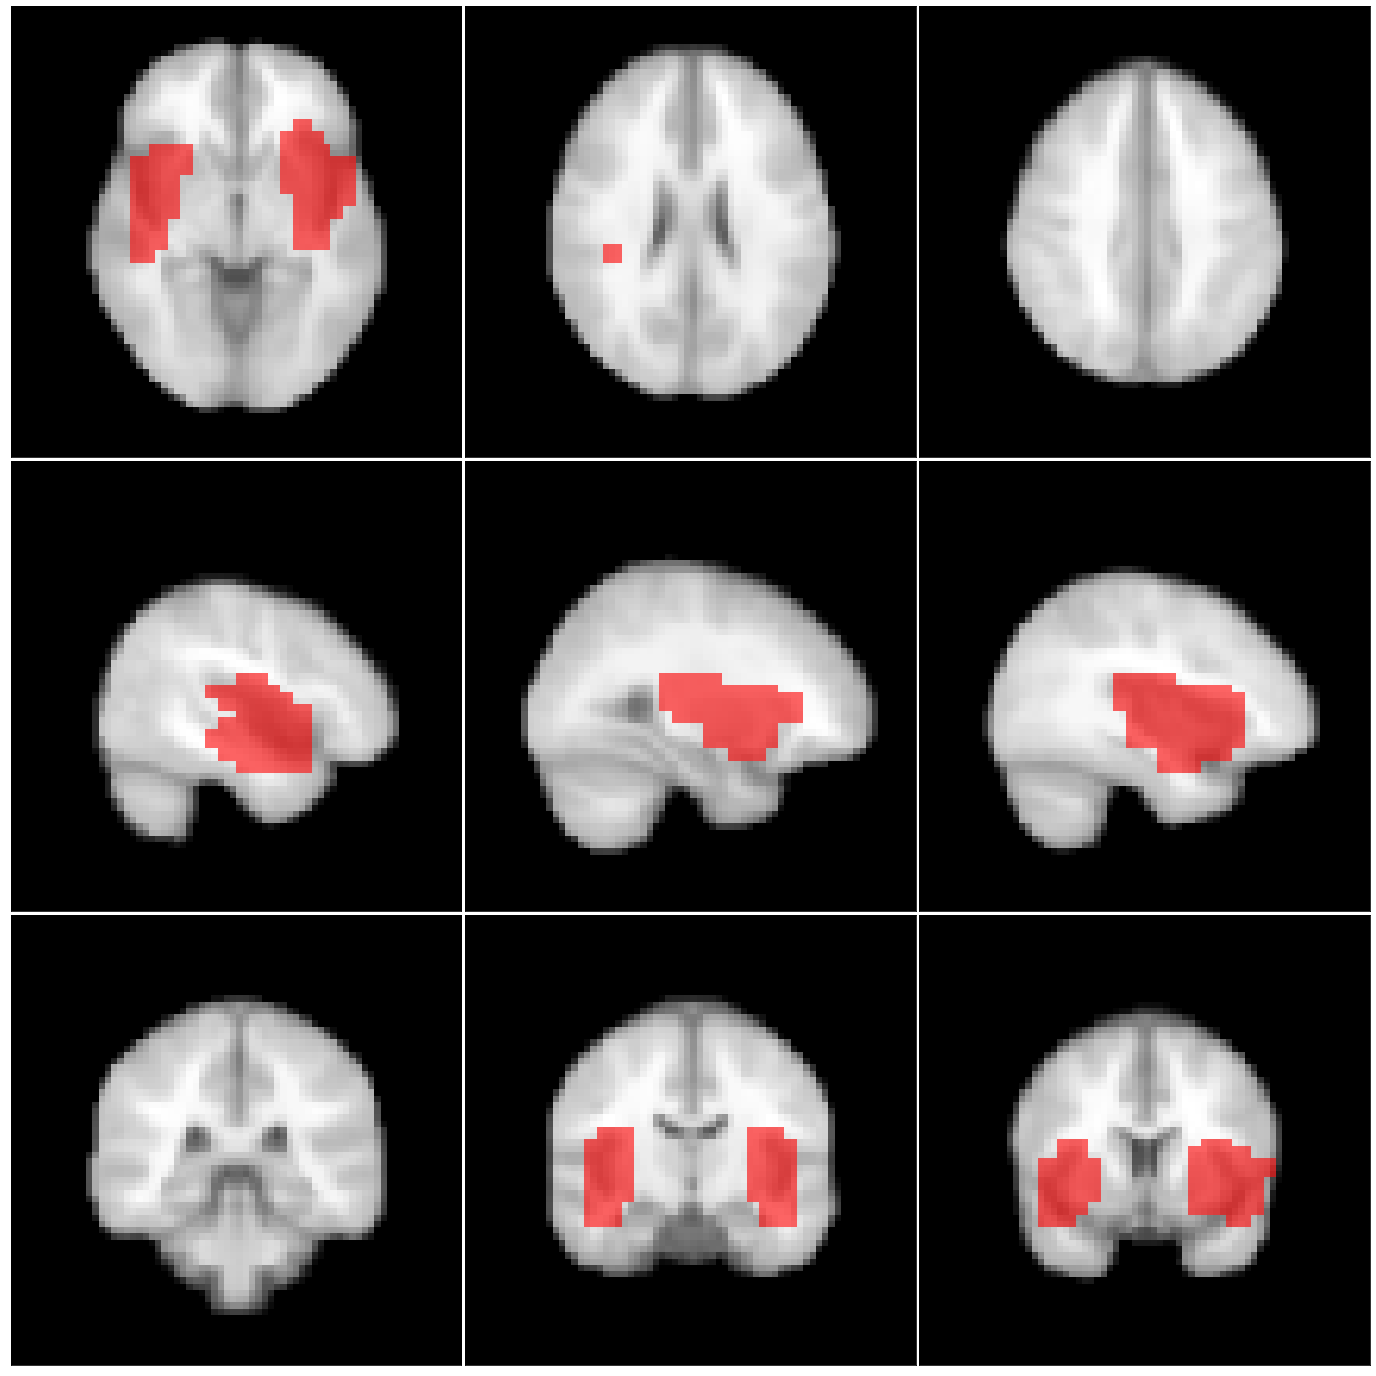

In [4]:
from mpl_toolkits.axes_grid1 import ImageGrid
from utils import viz_functional_parcellation

# LOAD A SIMULATED NEURAL SUBSTRATE -- IN YOUR CASE THIS WOULD BE UNKNOWN
neural_substrate = np.load('data/gt_9.npy')
print(neural_substrate.shape)

# LOAD A TEMPLATE BRAIN FOR VISUALISATION
fp = 'data/avg152T1_brain.nii.gz'
template_brain = nib.load(fp).get_fdata()
template_brain = template_brain[:-1, :-1, :-1]
template_brain = resize(template_brain, (60, 72, 60))

# LET'S VIZUALISE OUR NEURAL SUBSTRATE

views = [[22, 32, 37], [15, 20, 42], [30, 38, 45]]
slices_per_view = 3
viz_gt = resize(neural_substrate, (60, 72, 60))

fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(len(views), 3),
                 axes_pad=0.05,
                 share_all=True
                 )

grid[0].get_yaxis().set_ticks([])
grid[0].get_xaxis().set_ticks([])

acc = 0
for v_idx, v in enumerate(views):
    for slice_idx in range(slices_per_view):
        viz_functional_parcellation(viz_gt, grid[acc], v_idx, v[slice_idx],
                                    template_brain)
        acc += 1

(array([586., 637., 113.,  50.,  30.,  32.,  16.,  18.,   9.,   9.]),
 array([0.   , 0.055, 0.11 , 0.165, 0.22 , 0.275, 0.33 , 0.385, 0.44 ,
        0.495, 0.55 ]),
 <BarContainer object of 10 artists>)

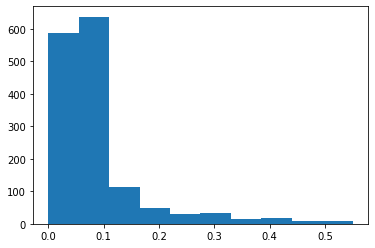

In [5]:
# LET'S SIMULATE SOME SCORES

# THIS IS THE AMOUNT OF NOISE TO ADD, USUALLY THERE WON'T BE CLEAN RELATIONSHIPS
noise = 0.1

# WE SIMULATE A CONTINUOUS SCORE BY TAKING THE OVERLAP OF THE LESION AND FUNCTIONAL PARCEL

deficit_scores = [0 for i in range(len(lesions))]
positive_indices = []
for i in range(len(lesions)):
    overlap = lesions[i] * neural_substrate
    counts = np.count_nonzero(overlap)
    voxels_gt = np.sum(neural_substrate)
    ratio_lesion = counts / voxels_gt

    deficit_scores[i] = ratio_lesion 
    
    if noise > 0:
        vox_noise = np.random.uniform(0, 1)
        deficit_scores[i] = (1- noise) * deficit_scores[i] + noise * vox_noise

    deficit_scores[i] = round(deficit_scores[i], 2)
                
deficit_scores = np.array(deficit_scores)
plt.hist(deficit_scores)

GIVEN AN ENTIRE DATASET, NOW IN TYPICAL MACHINE LEARNING FASHION WE NEED TO SPLIT THE DATA

FOR TRAINING THE MODEL WE USE:
  - TRAINING
  - VALIDATION
  
 
FOR THRESHOLDING THE INFERENCE MAP WE THEN USE:
  - CALIBRATION

In [6]:
from sklearn.model_selection import train_test_split

# WE NEED TO ADD ONE EXTRA CHANNEL AS DL MODELS EXPECT A COLOUR CHANNEL
lesions = np.expand_dims(lesions, axis=1)

# FIRST SPLIT INTO 90/10
train_data, vc_data, train_labels, vc_labels = train_test_split(lesions,
                                                                deficit_scores,
                                                                test_size=0.1)

# THEN SPLIT THE REMAINING 10% INTO VALIDATION AND CALIBRATION - 50/50
val_data, cal_data, val_labels, cal_labels = train_test_split(vc_data,
                                                              vc_labels,
                                                              test_size=0.5)

train_data.shape, val_data.shape, cal_data.shape

((1350, 1, 32, 32, 32), (75, 1, 32, 32, 32), (75, 1, 32, 32, 32))

GIVEN THE DATASET, WE CREATE PYTORCH DATALOADERS TO ITERATE IN A BATCH-WISE MANNER
IF THE LABELS ARE CONTINUOUS SCORES WE NEED TO NORMALISE THEM FIRST

In [7]:
from torch.utils.data import Dataset, DataLoader

batch_size = 256

# NORMALISE LABELS FIRST
n_train_labels = (train_labels - deficit_scores.mean()) / deficit_scores.std()
n_val_labels = (val_labels - deficit_scores.mean()) / deficit_scores.std()
n_cal_labels = (cal_labels - deficit_scores.mean()) / deficit_scores.std()

# CREATE DATA LOADERS
# TRAINING
dataset = DeficitDataset(data=train_data, labels=n_train_labels)
train_loader = DataLoader(dataset, batch_size=batch_size, drop_last=False,
                                            shuffle=True, num_workers=0, pin_memory=True)

# VALIDATION
val_dataset = DeficitDataset(data=val_data, labels=n_val_labels)
val_loader = DataLoader(val_dataset, batch_size=batch_size, drop_last=False,
                                            shuffle=True, num_workers=0, pin_memory=True)

# CALIBRATION
cal_dataset = DeficitDataset(data=cal_data, labels=n_cal_labels)
cal_loader = DataLoader(cal_dataset, batch_size=batch_size, drop_last=False,
                                            shuffle=True, num_workers=0, pin_memory=True)


device = torch.device("cuda:0")

WE NOW LOAD IN OUR MODEL

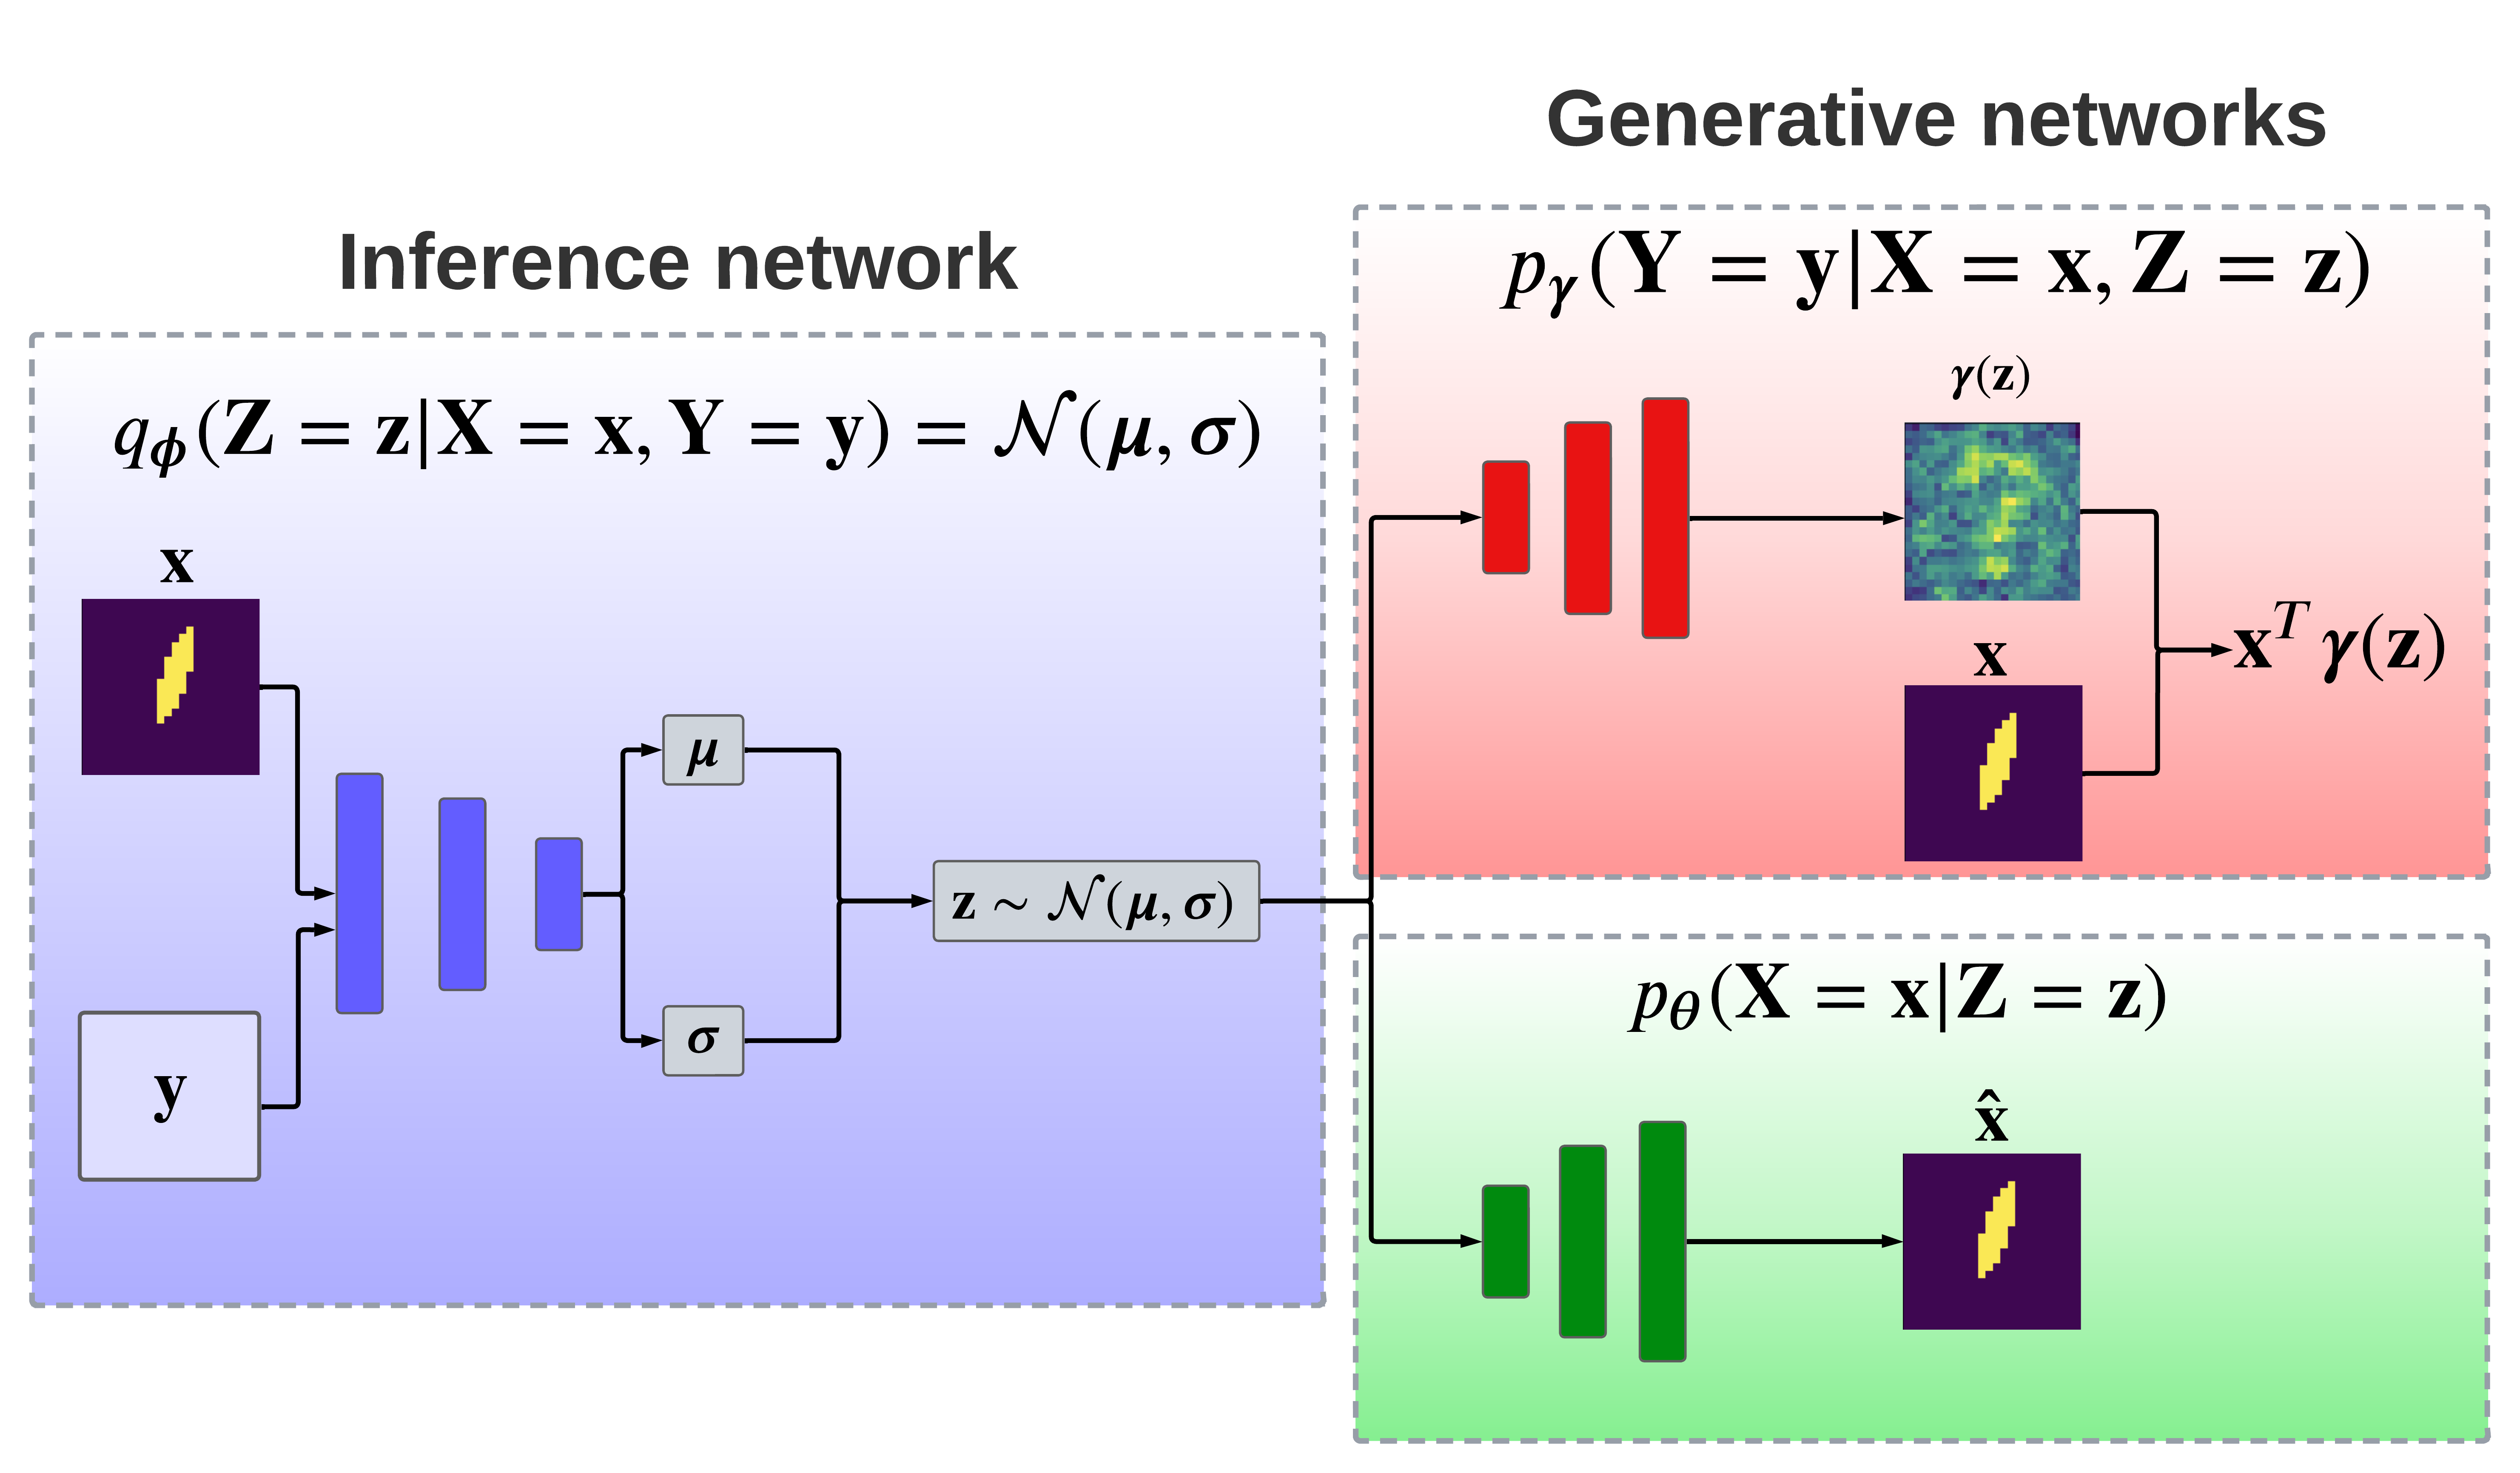

In [8]:
dist_path = 'imgs/vae_ldm_diagram.png'
Image(filename=dist_path, width=1000, height=100)

In [9]:
# THE MODEL CONFIGURATION - CAN BE CHANGED FOR BETTER PERFORMANCE,BUT THE DEFAULTS WORK WELL

# FIRST ELEMENT IS THE SIZE OF THE VOLUMES IN VOXELS
# CURRENTLY CUBE IMAGES ARE REQUIRED - PAD WITH 0 IF YOUR IMAGE IS NOT CUBED
INPUT_SIZE = 32

# SECONDLY THE NATURE OF THE DEFICIT SCORES: THEY CAN BE CONTINUOUS, OR NOT
CONTINUOUS = True

# THIRDLY THE NUMBER OF LATENT VARIABLES USED TO MODEL THE INFERENCE
Z_DIM = 50

# THE REST OF THE PARAMETERS ARE COVERED IN OUR PAPER
EPOCHS = 200
INITIAL_CONV_KERNELS = 16
L2_REG = 1e-4
LR = 1e-3

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

Tensor = torch.cuda.FloatTensor

model = ModelWrapper(INPUT_SIZE,
                     z_dim=Z_DIM,
                     start_dims=INITIAL_CONV_KERNELS,
                     continuous=CONTINUOUS).to(device)

# Other optimisers work as well, Adamax is quite stable though
optimizer = optim.Adamax(model.parameters(),
                         weight_decay=L2_REG,
                         lr=LR)

print('NUM PARAMS: {}'.format(count_parameters(model)))
print(f'NUM EPOCHS: {EPOCHS}')

CONTINUOUS MODEL: True


/home/gp/anaconda3/lib/python3.7/site-packages/torch/cuda/__init__.py:120: UserWarning: 
    Found GPU%d %s which is of cuda capability %d.%d.
    PyTorch no longer supports this GPU because it is too old.
    The minimum cuda capability supported by this library is %d.%d.
    
  warnings.warn(old_gpu_warn.format(d, name, major, minor, min_arch // 10, min_arch % 10))


NUM PARAMS: 1038923
NUM EPOCHS: 200


HAVING INITIALIZED THE MODEL, NOW TRAIN IT

Epoch: 0, mask likelihood: 0.8739931583404541, KL: 8.277, recon likelihood: 20302.814453125
Best: 0.8739931583404541, 20311.96484375, 0.874, epoch: 0


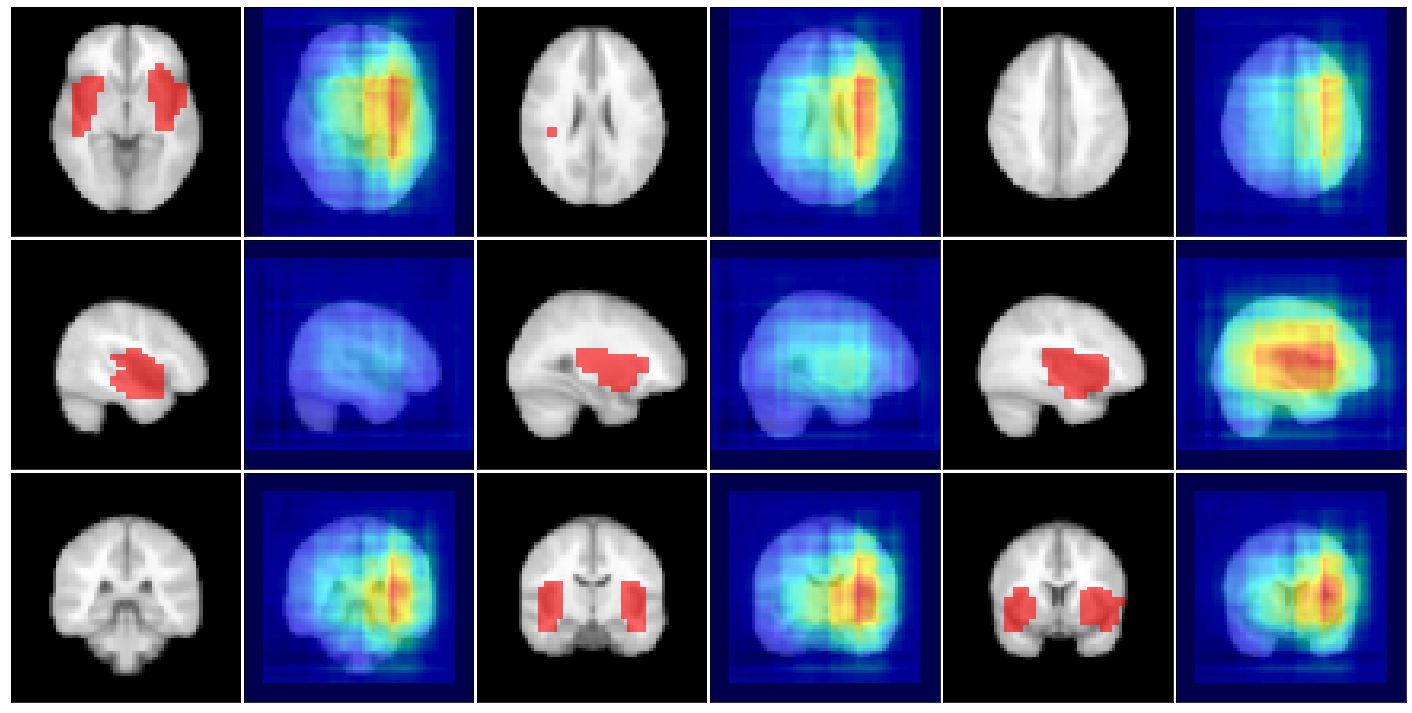

Epoch: 1, mask likelihood: 0.8694412708282471, KL: 6.975, recon likelihood: 18634.349609375
Epoch: 2, mask likelihood: 0.8642858862876892, KL: 11.317, recon likelihood: 17205.076171875
Epoch: 3, mask likelihood: 0.8579483032226562, KL: 16.941, recon likelihood: 15717.330078125
Epoch: 4, mask likelihood: 0.8502564430236816, KL: 20.347, recon likelihood: 14473.107421875
Epoch: 5, mask likelihood: 0.8380712866783142, KL: 19.833, recon likelihood: 13408.1474609375
Epoch: 6, mask likelihood: 0.8264754414558411, KL: 20.352, recon likelihood: 12434.5458984375
Epoch: 7, mask likelihood: 0.8198763132095337, KL: 21.934, recon likelihood: 11583.544921875
Epoch: 8, mask likelihood: 0.8121235966682434, KL: 22.632, recon likelihood: 10635.3935546875
Epoch: 9, mask likelihood: 0.8024491667747498, KL: 23.297, recon likelihood: 9801.587890625
Epoch: 10, mask likelihood: 0.8021666407585144, KL: 24.238, recon likelihood: 9006.95703125
Best: 0.8021666407585144, 9031.9970703125, 0.8022, epoch: 10
Epoch: 11

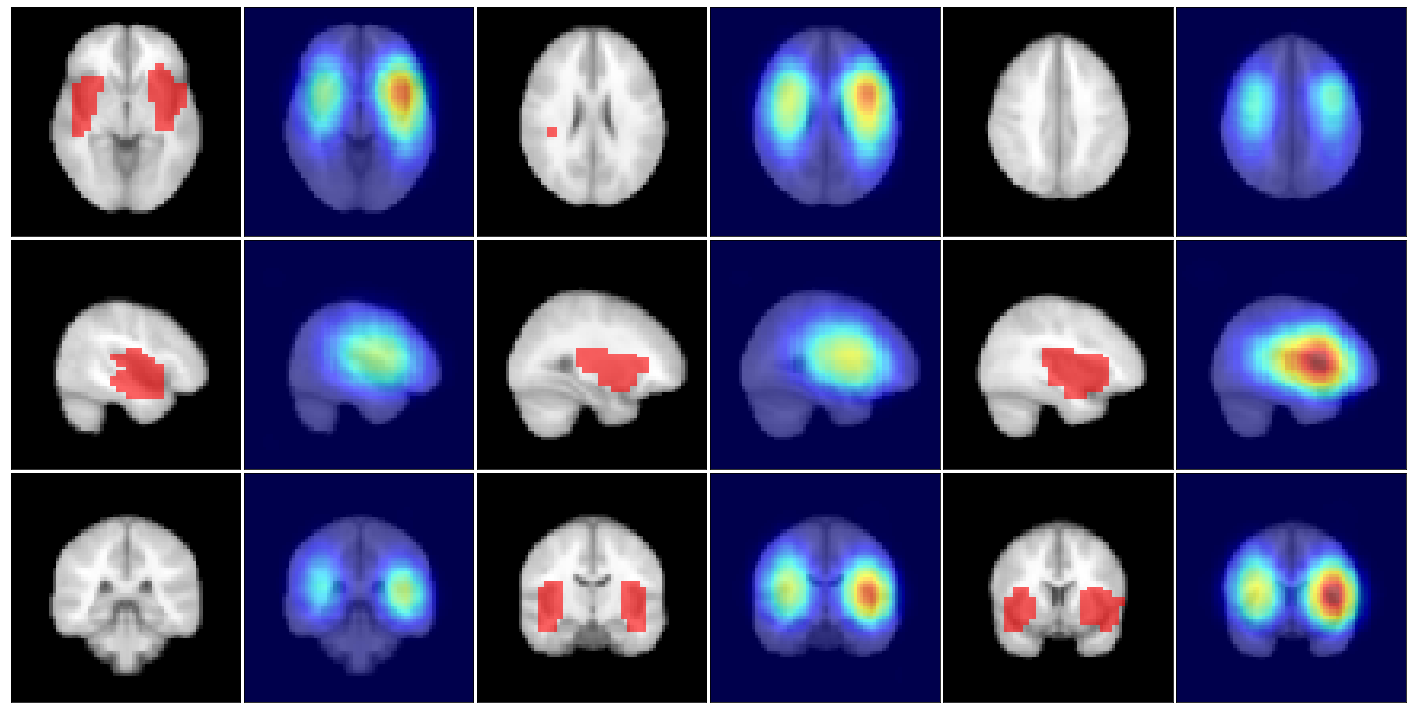

Epoch: 21, mask likelihood: 0.7260676026344299, KL: 26.144, recon likelihood: 3614.8505859375
Epoch: 22, mask likelihood: 0.7084923386573792, KL: 25.216, recon likelihood: 3450.767578125
Epoch: 23, mask likelihood: 0.7030789852142334, KL: 24.11, recon likelihood: 3013.27001953125
Epoch: 24, mask likelihood: 0.6968193650245667, KL: 23.521, recon likelihood: 2808.846435546875
Epoch: 25, mask likelihood: 0.6768020391464233, KL: 23.023, recon likelihood: 2633.580810546875
Epoch: 26, mask likelihood: 0.6616212129592896, KL: 22.216, recon likelihood: 2468.685302734375
Epoch: 27, mask likelihood: 0.6539431810379028, KL: 21.95, recon likelihood: 2337.427978515625
Epoch: 28, mask likelihood: 0.6413916349411011, KL: 21.955, recon likelihood: 2222.780029296875
Epoch: 29, mask likelihood: 0.6479191184043884, KL: 21.491, recon likelihood: 2112.70556640625
Epoch: 30, mask likelihood: 0.6501536965370178, KL: 22.163, recon likelihood: 2176.430419921875
Best: 0.6413916349411011, 2245.37646484375, 0.641

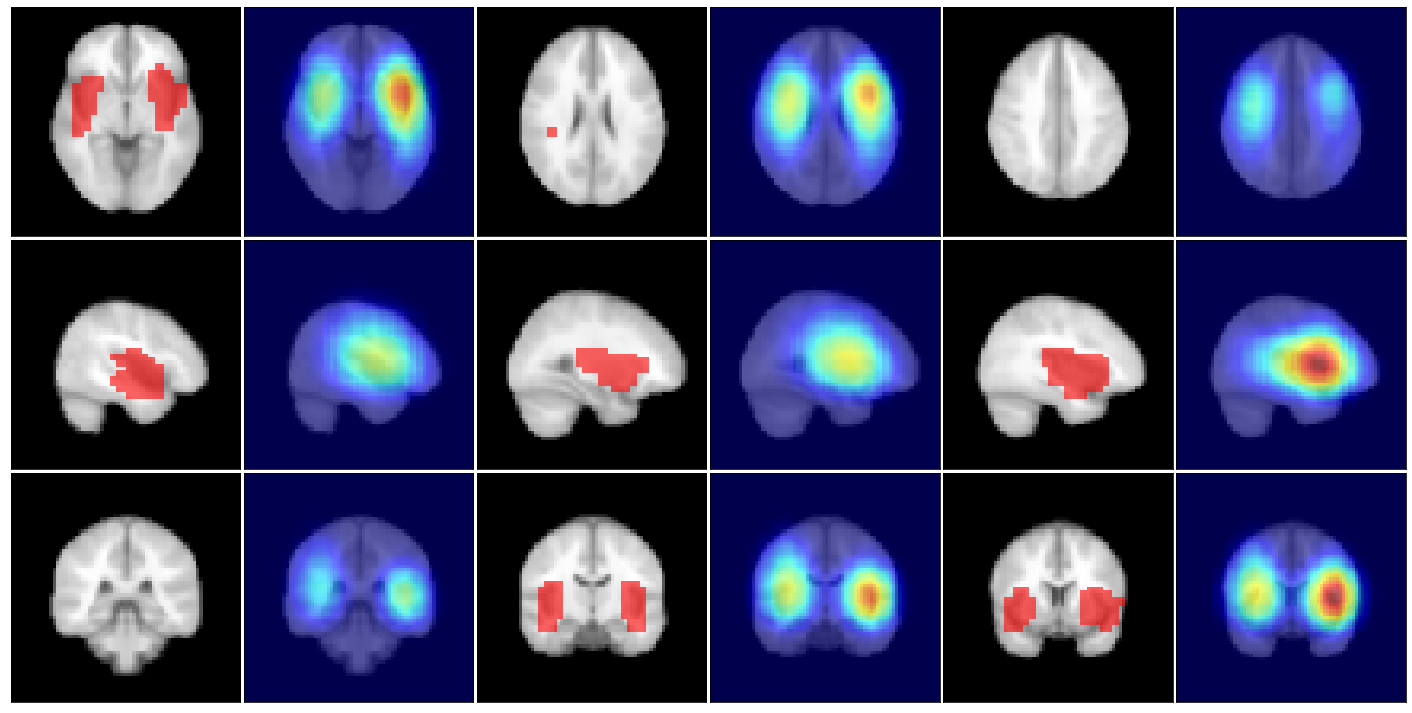

Epoch: 41, mask likelihood: 0.5244826078414917, KL: 21.987, recon likelihood: 1626.3536376953125
Epoch: 42, mask likelihood: 0.532191812992096, KL: 21.988, recon likelihood: 1552.513427734375
Epoch: 43, mask likelihood: 0.5277699828147888, KL: 21.868, recon likelihood: 1489.0098876953125
Epoch: 44, mask likelihood: 0.5096229314804077, KL: 21.836, recon likelihood: 1434.2763671875
Epoch: 45, mask likelihood: 0.495388001203537, KL: 21.733, recon likelihood: 1373.2064208984375
Epoch: 46, mask likelihood: 0.4889501929283142, KL: 21.724, recon likelihood: 1326.41845703125
Epoch: 47, mask likelihood: 0.48985618352890015, KL: 21.567, recon likelihood: 1273.701171875
Epoch: 48, mask likelihood: 0.4749787449836731, KL: 21.491, recon likelihood: 1239.3272705078125
Epoch: 49, mask likelihood: 0.4767053425312042, KL: 21.404, recon likelihood: 1207.5074462890625
Epoch: 50, mask likelihood: 0.46756237745285034, KL: 21.339, recon likelihood: 1162.34619140625
Best: 0.46756237745285034, 1184.1530761718

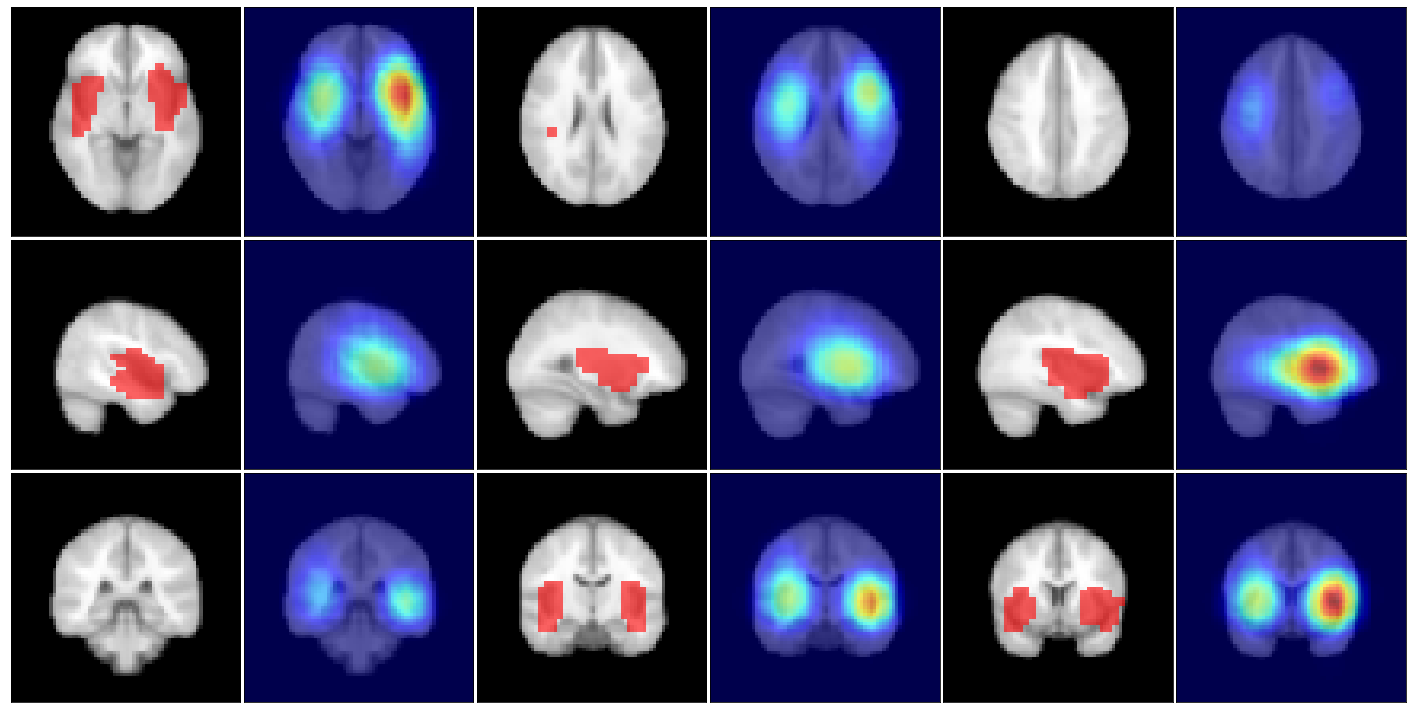

Epoch: 61, mask likelihood: 0.4135168790817261, KL: 20.35, recon likelihood: 928.765625
Epoch: 62, mask likelihood: 0.3947491943836212, KL: 20.277, recon likelihood: 923.1189575195312
Epoch: 63, mask likelihood: 0.3891497254371643, KL: 20.184, recon likelihood: 917.3621826171875
Epoch: 64, mask likelihood: 0.38109272718429565, KL: 20.11, recon likelihood: 897.8504638671875
Epoch: 65, mask likelihood: 0.37063512206077576, KL: 20.05, recon likelihood: 876.014892578125
Epoch: 66, mask likelihood: 0.3566378355026245, KL: 19.964, recon likelihood: 867.0850830078125
Epoch: 67, mask likelihood: 0.3575764000415802, KL: 19.846, recon likelihood: 868.7659301757812
Epoch: 68, mask likelihood: 0.35898736119270325, KL: 19.715, recon likelihood: 847.6924438476562
Epoch: 69, mask likelihood: 0.34652966260910034, KL: 19.617, recon likelihood: 846.5249633789062
Epoch: 70, mask likelihood: 0.3448962867259979, KL: 19.514, recon likelihood: 834.6279296875
Best: 0.3448962867259979, 854.4869995117188, 0.344

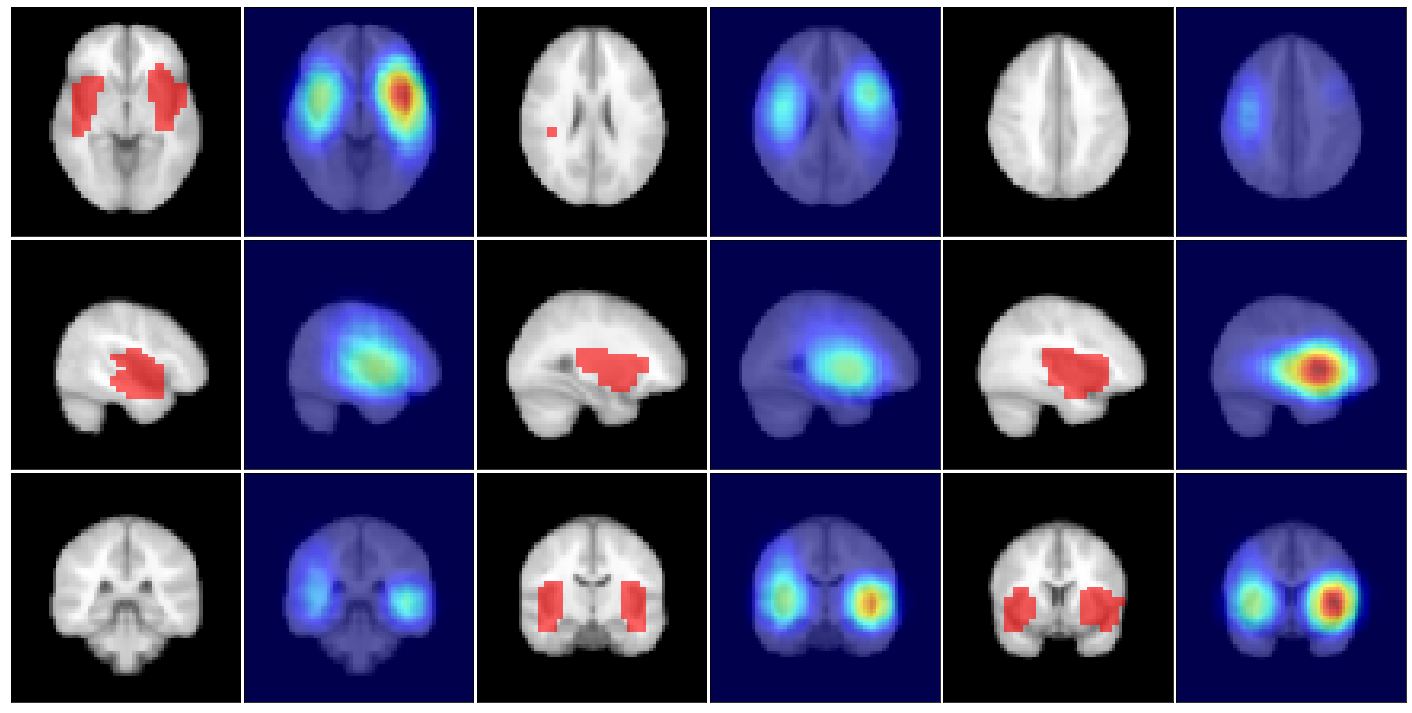

Epoch: 81, mask likelihood: 0.31628504395484924, KL: 18.237, recon likelihood: 763.38818359375
Epoch: 82, mask likelihood: 0.30447331070899963, KL: 18.132, recon likelihood: 744.8151245117188
Epoch: 83, mask likelihood: 0.2984253466129303, KL: 18.004, recon likelihood: 738.2321166992188
Epoch: 84, mask likelihood: 0.298554003238678, KL: 17.887, recon likelihood: 747.5288696289062
Epoch: 85, mask likelihood: 0.29460251331329346, KL: 17.785, recon likelihood: 738.5151977539062
Epoch: 86, mask likelihood: 0.2875421345233917, KL: 17.659, recon likelihood: 719.582275390625
Epoch: 87, mask likelihood: 0.2910178601741791, KL: 17.54, recon likelihood: 736.8512573242188
Epoch: 88, mask likelihood: 0.2865707576274872, KL: 17.44, recon likelihood: 717.1306762695312
Epoch: 89, mask likelihood: 0.2789776027202606, KL: 17.332, recon likelihood: 701.0617065429688
Epoch: 90, mask likelihood: 0.2812134921550751, KL: 17.22, recon likelihood: 708.184326171875
Best: 0.2789776027202606, 718.67236328125, 0.

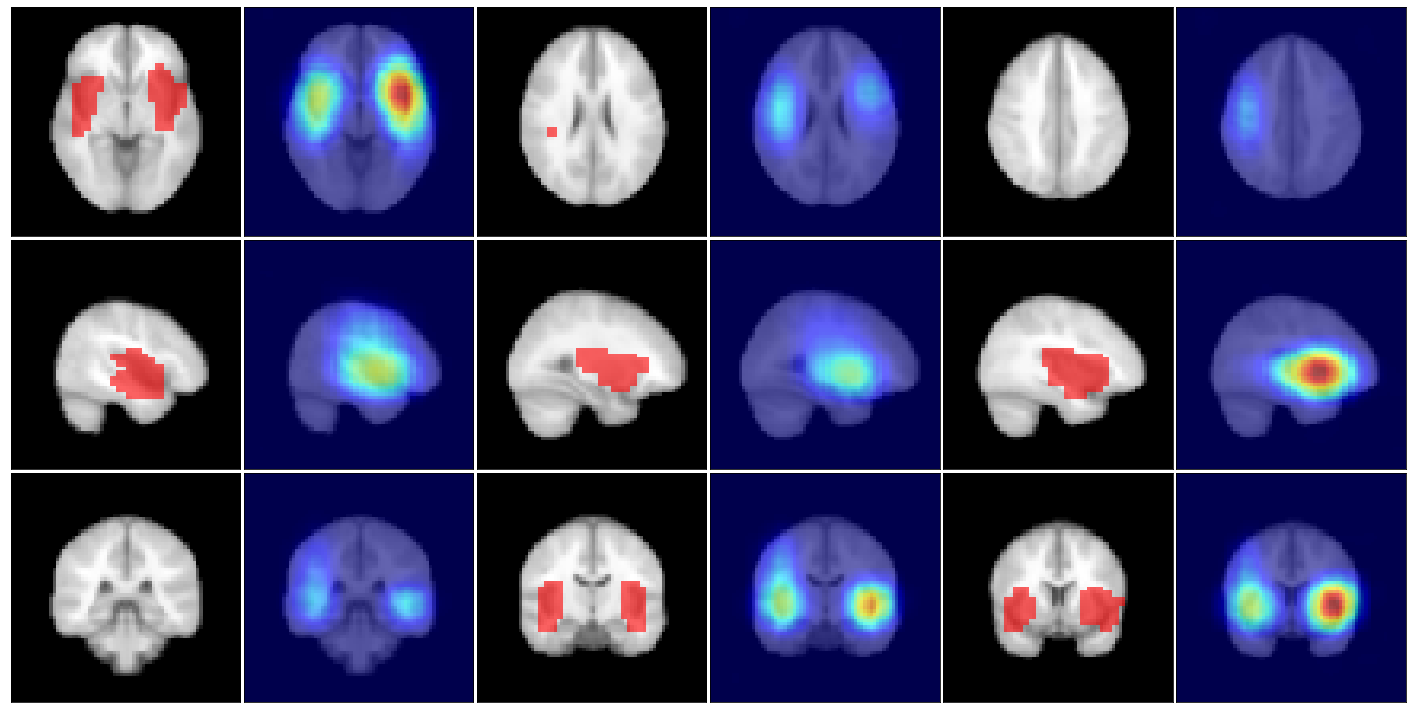

Epoch: 101, mask likelihood: 0.2639593183994293, KL: 16.001, recon likelihood: 674.1943969726562
Epoch: 102, mask likelihood: 0.2603023648262024, KL: 15.91, recon likelihood: 668.193115234375
Epoch: 103, mask likelihood: 0.2539547383785248, KL: 15.807, recon likelihood: 665.4491577148438
Epoch: 104, mask likelihood: 0.25386109948158264, KL: 15.677, recon likelihood: 676.8840942382812
Epoch: 105, mask likelihood: 0.25772982835769653, KL: 15.593, recon likelihood: 670.0264892578125
Epoch: 106, mask likelihood: 0.2570866048336029, KL: 15.461, recon likelihood: 662.88818359375
Epoch: 107, mask likelihood: 0.24967023730278015, KL: 15.35, recon likelihood: 662.460205078125
Epoch: 108, mask likelihood: 0.2511724531650543, KL: 15.276, recon likelihood: 682.029052734375
Epoch: 109, mask likelihood: 0.251275897026062, KL: 15.18, recon likelihood: 658.0294799804688
Epoch: 110, mask likelihood: 0.24676722288131714, KL: 15.098, recon likelihood: 649.1870727539062
Best: 0.24676722288131714, 664.5318

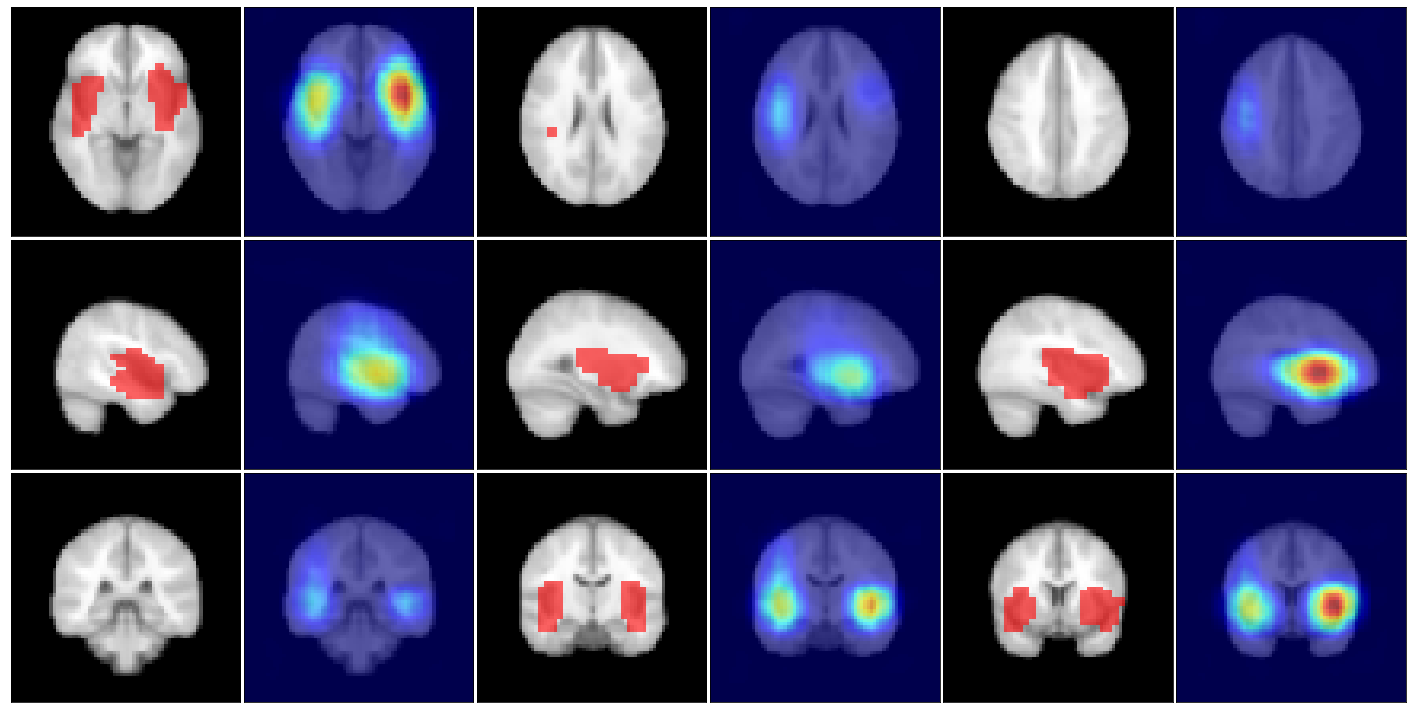

Epoch: 121, mask likelihood: 0.24265620112419128, KL: 14.179, recon likelihood: 633.166748046875
Epoch: 122, mask likelihood: 0.23954010009765625, KL: 14.087, recon likelihood: 632.1184692382812
Epoch: 123, mask likelihood: 0.236845001578331, KL: 14.001, recon likelihood: 640.1990966796875
Epoch: 124, mask likelihood: 0.2369474321603775, KL: 13.95, recon likelihood: 632.7755126953125
Epoch: 125, mask likelihood: 0.23950287699699402, KL: 13.907, recon likelihood: 643.0175170898438
Epoch: 126, mask likelihood: 0.234904482960701, KL: 13.827, recon likelihood: 627.1300659179688
Epoch: 127, mask likelihood: 0.23235636949539185, KL: 13.768, recon likelihood: 624.8237915039062
Epoch: 128, mask likelihood: 0.23392850160598755, KL: 13.706, recon likelihood: 628.0726318359375
Epoch: 129, mask likelihood: 0.23318740725517273, KL: 13.589, recon likelihood: 634.0034790039062
Epoch: 130, mask likelihood: 0.2302888035774231, KL: 13.483, recon likelihood: 623.1421508789062
Best: 0.2302888035774231, 63

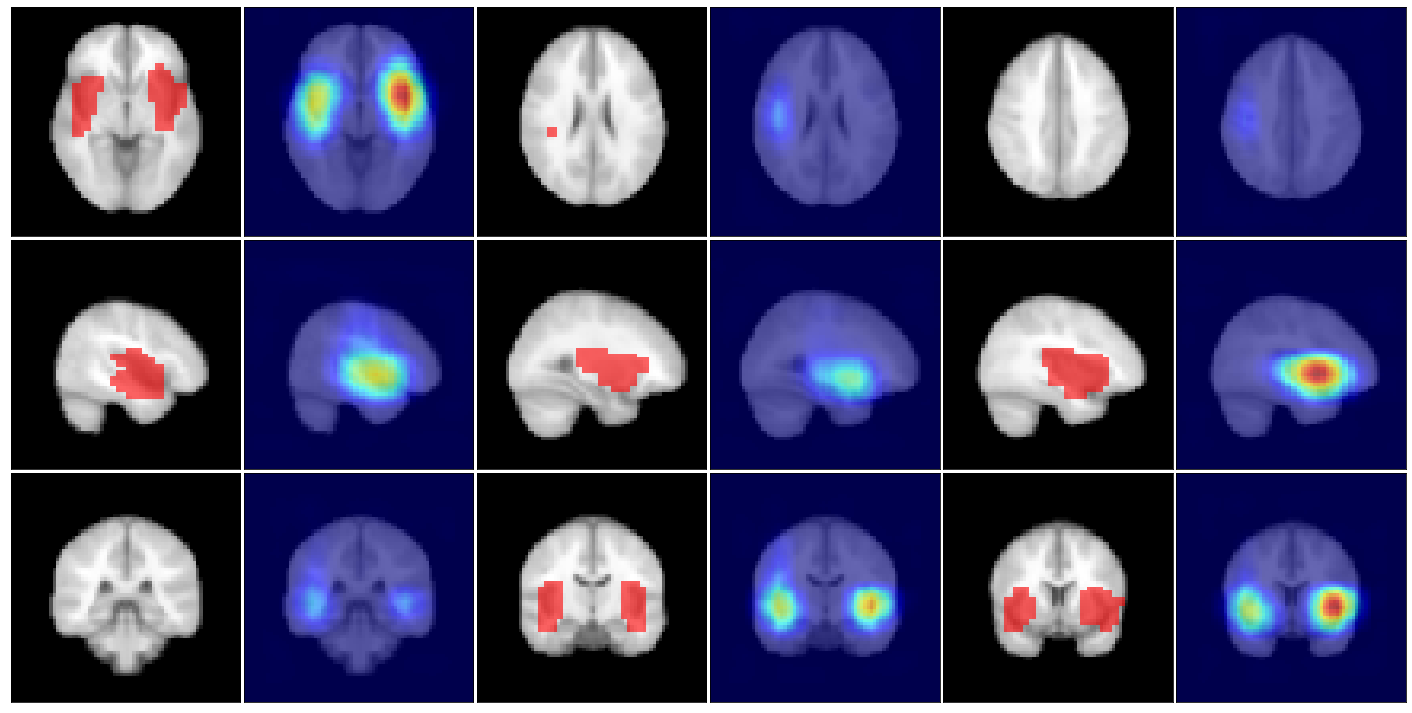

Epoch: 141, mask likelihood: 0.2254854440689087, KL: 12.841, recon likelihood: 615.7233276367188
Epoch: 142, mask likelihood: 0.22440992295742035, KL: 12.78, recon likelihood: 595.3768920898438
Epoch: 143, mask likelihood: 0.2262599766254425, KL: 12.73, recon likelihood: 608.3897094726562
Epoch: 144, mask likelihood: 0.22417041659355164, KL: 12.708, recon likelihood: 607.6293334960938
Epoch: 145, mask likelihood: 0.22348305583000183, KL: 12.687, recon likelihood: 612.0052490234375
Epoch: 146, mask likelihood: 0.22676362097263336, KL: 12.64, recon likelihood: 629.3431396484375
Epoch: 147, mask likelihood: 0.22136548161506653, KL: 12.673, recon likelihood: 607.1119995117188
Epoch: 148, mask likelihood: 0.22156967222690582, KL: 13.025, recon likelihood: 626.9125366210938
Epoch: 149, mask likelihood: 0.22527194023132324, KL: 13.178, recon likelihood: 622.2868041992188
Epoch: 150, mask likelihood: 0.22138288617134094, KL: 13.187, recon likelihood: 624.5767822265625
Best: 0.22136548161506653

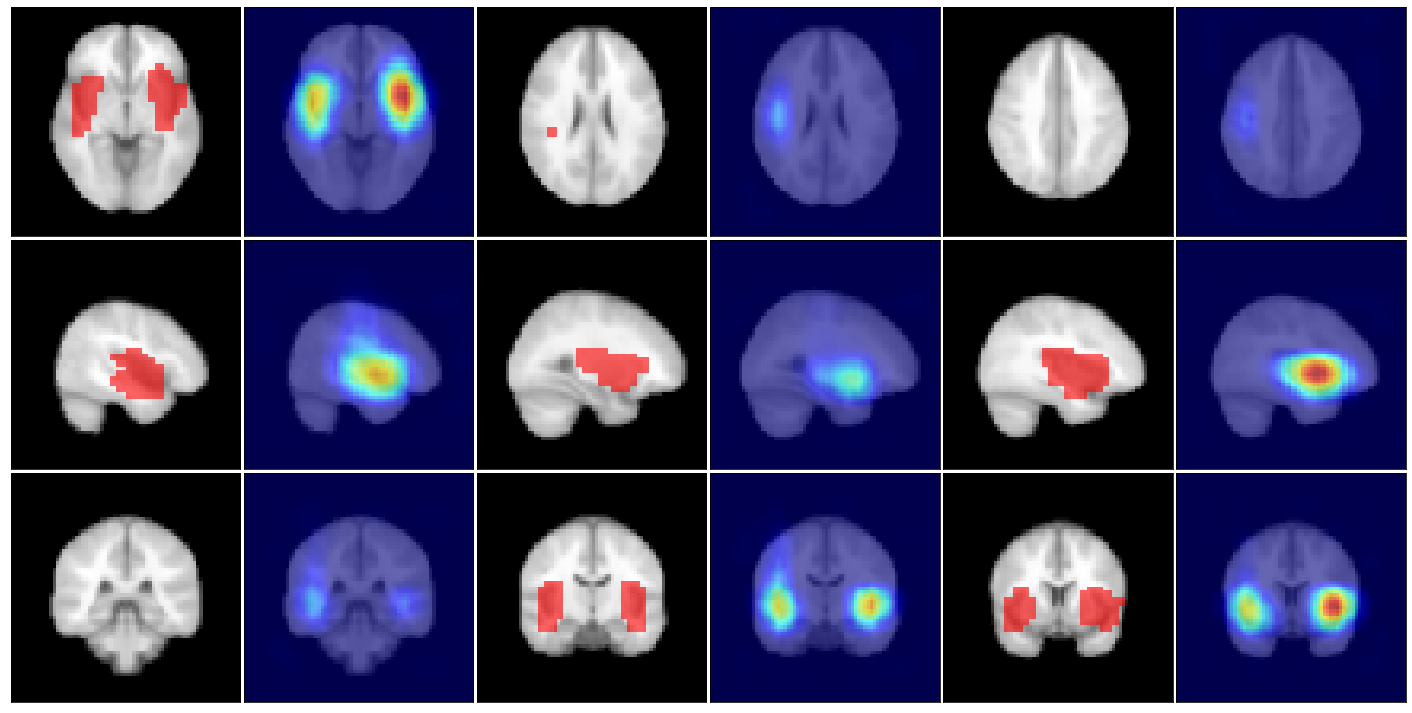

Epoch: 161, mask likelihood: 0.2161775827407837, KL: 12.188, recon likelihood: 608.7393798828125
Epoch: 162, mask likelihood: 0.21552103757858276, KL: 12.128, recon likelihood: 595.6460571289062
Epoch: 163, mask likelihood: 0.2158641666173935, KL: 12.066, recon likelihood: 620.563232421875
Epoch: 164, mask likelihood: 0.21790561079978943, KL: 11.997, recon likelihood: 598.2021484375
Epoch: 165, mask likelihood: 0.21638822555541992, KL: 11.947, recon likelihood: 589.5196533203125
Epoch: 166, mask likelihood: 0.21869787573814392, KL: 11.9, recon likelihood: 594.1254272460938
Epoch: 167, mask likelihood: 0.21982580423355103, KL: 11.876, recon likelihood: 609.6708374023438
Epoch: 168, mask likelihood: 0.21582487225532532, KL: 11.87, recon likelihood: 592.764404296875
Epoch: 169, mask likelihood: 0.2149335741996765, KL: 11.824, recon likelihood: 589.1558227539062
Epoch: 170, mask likelihood: 0.21437226235866547, KL: 11.806, recon likelihood: 589.1343994140625
Best: 0.21437226235866547, 601.

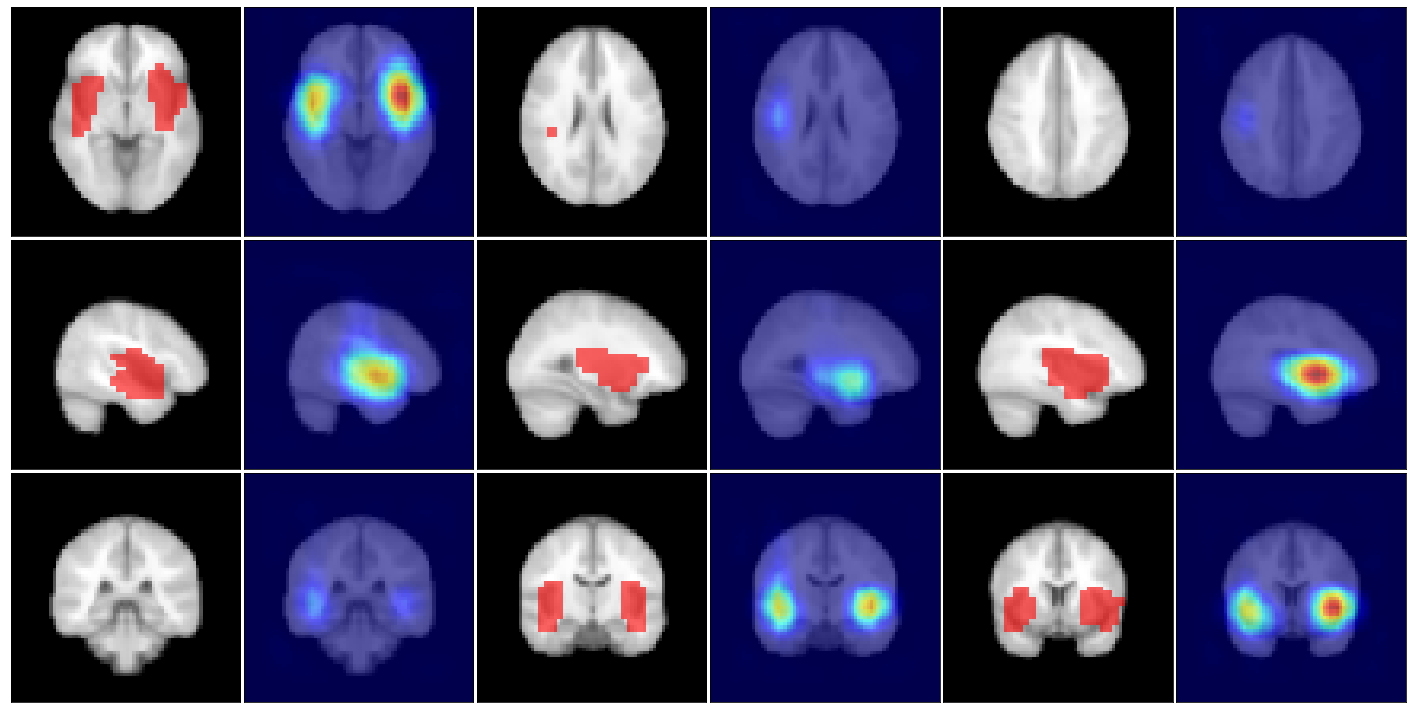

Epoch: 181, mask likelihood: 0.21250958740711212, KL: 11.427, recon likelihood: 589.040771484375
Epoch: 182, mask likelihood: 0.21196743845939636, KL: 11.419, recon likelihood: 572.8680419921875
Epoch: 183, mask likelihood: 0.21302399039268494, KL: 11.395, recon likelihood: 586.3634033203125
Epoch: 184, mask likelihood: 0.21258097887039185, KL: 11.382, recon likelihood: 568.5111694335938
Epoch: 185, mask likelihood: 0.21255962550640106, KL: 11.394, recon likelihood: 568.5469970703125
Epoch: 186, mask likelihood: 0.21285024285316467, KL: 11.387, recon likelihood: 558.3367919921875
Epoch: 187, mask likelihood: 0.21264803409576416, KL: 11.385, recon likelihood: 556.937744140625
Epoch: 188, mask likelihood: 0.2122492641210556, KL: 11.382, recon likelihood: 564.9617919921875
Epoch: 189, mask likelihood: 0.21177689731121063, KL: 11.339, recon likelihood: 555.6278076171875
Epoch: 190, mask likelihood: 0.21166445314884186, KL: 11.266, recon likelihood: 550.4263916015625
Best: 0.211664453148841

In [10]:
best_loss = 1e30
best_acc = 0
best_lk = 1e30
global_step = 0

training_losses = []
validation_losses = []

for epoch in range(EPOCHS):
    model.zero_grad()
    train_acc = 0
    t_epoch_loss = 0

    # The trackers for the mean and scale of the inference map
    vae_mask = np.zeros((INPUT_SIZE, INPUT_SIZE, INPUT_SIZE))
    vae_scale = np.zeros((INPUT_SIZE, INPUT_SIZE, INPUT_SIZE))

    for (x, y) in train_loader:
        optimizer.zero_grad()

        x = x.type(Tensor).to(device)
        y = y.type(Tensor).to(device)

        ret_dict = model(x, y)

        loss = ret_dict['loss'].mean()
        t_epoch_loss += loss.item()

        loss.backward()
        optimizer.step()

        vae_mask += np.squeeze(ret_dict['mean_mask'].cpu().data.numpy())
        vae_scale += np.squeeze(ret_dict['mask_scale'].cpu().data.numpy())
        train_acc += 1
        global_step += 1
        
    training_losses.append(t_epoch_loss / train_acc)

    vae_mask = vae_mask / train_acc
    val_mask = tc.from_numpy(vae_mask).type(Tensor).to(device).view(1, 1,
                                                                    INPUT_SIZE,
                                                                    INPUT_SIZE,
                                                                    INPUT_SIZE)
    vae_scale = vae_scale / train_acc
    val_scale = tc.from_numpy(vae_scale).type(Tensor).to(device).view(1, 1,
                                                                    INPUT_SIZE,
                                                                    INPUT_SIZE,
                                                                    INPUT_SIZE)

    val_acc = 0
    accuracy_acc = 0
    loss_acc = 0
    likelihood_acc = 0
    kld_acc = 0
    recon_acc = 0
    with torch.no_grad():
        for (x, y) in val_loader:
            x = x.type(Tensor).to(device)
            y = y.type(Tensor).to(device)

            ret_dict = model(x, y,
                             provided_mask=val_mask,
                             provided_scale=val_scale,
                             val=True)

            loss_acc += ret_dict['loss'].mean().item()
            val_acc += 1
            likelihood_acc += ret_dict['mask_ll'].item()
            accuracy_acc += ret_dict['acc'].item()
            kld_acc += ret_dict['kl'].item()
            recon_acc += ret_dict['recon_ll'].item()

    loss = loss_acc / val_acc
    validation_losses.append(loss)
    lk = likelihood_acc / val_acc
    acc = round(accuracy_acc / val_acc, 4)
    kl = round(kld_acc / val_acc, 3)
    rec = recon_acc / val_acc

    print(f'Epoch: {epoch}, mask likelihood: {lk}, KL: {kl}, recon likelihood: {rec}')
    
    if lk < best_lk:
        best_loss = loss
        best_lk = lk
        best_acc = acc
        best_recon = recon_acc
        best_epoch = epoch
        torch.save(model, f"vae.pth")
        np.save(f'vae_mask.npy', vae_mask)
        np.save(f'vae_scale.npy', vae_scale)
    
    if epoch % 10 == 0:
        print(f'Best: {best_lk}, {best_loss}, {best_acc}, epoch: {best_epoch}')
        
    # VIZUALISE AS THE TRAINING GOES ON
    if epoch % 20 == 0:

        subtitle_fontsize = 30

        imgs = x.cpu().data.numpy()

        question_mark = ret_dict['mean_mask'].cpu().data.numpy()

        b, c, h, w, d = imgs.shape
        imgs = np.reshape(imgs, [-1, h, w, d])
        question_mark = np.reshape(question_mark, [-1, h, w, d])
        mask_scale = np.reshape(vae_mask, [1, h, w, d])
        vmax = mask_scale.max()
        vmin = mask_scale.min()
        
        views = [[22, 32, 37], [15, 20, 42], [30, 38, 45]]
        slices_per_view = 3
        viz_gt = resize(neural_substrate, (60, 72, 60))
        viz_recovered = resize(vae_mask, (60, 72, 60))

        fig = plt.figure(figsize=(25., 25.))
        grid = ImageGrid(fig, 111, 
                         nrows_ncols=(len(views), 6),
                         axes_pad=0.05,
                         share_all=True
                         )

        grid[0].get_yaxis().set_ticks([])
        grid[0].get_xaxis().set_ticks([])

        acc = 0
        for v_idx, v in enumerate(views):
            for slice_idx in range(slices_per_view):
                viz_functional_parcellation(viz_gt, grid[acc], v_idx, v[slice_idx],
                                            template_brain)
                acc += 1
                viz_functional_parcellation(viz_recovered, grid[acc], v_idx, v[slice_idx],
                                            template_brain, cmap='jet', vmin=vmin,
                                            vmax=vmax)
                acc += 1

        plt.show()

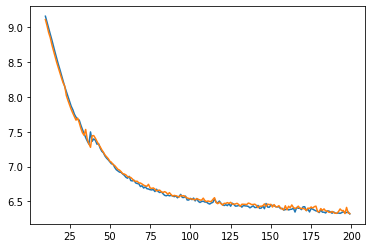

In [13]:
import math

executed_epochs = [i for i in range(len(training_losses))]
train_log_loss = [math.log(l) for l in training_losses]
val_log_loss = [math.log(l) for l in validation_losses]

plt.plot(executed_epochs[10:], train_log_loss[10:])
plt.plot(executed_epochs[10:], val_log_loss[10:])

WE USE THE MASK AT THE EPOCH THAT GETS THE BEST PREDICTIVE PERFORMANCE
WE THEN USE THE CALIBRATION SET TO THRESHOLD IT

In [21]:
# CALIBRATE OUR MASK

# model = ModelWrapper(np.mean(data, axis=0)).to(device)
model = torch.load("vae.pth")
model.eval()
vae_mask = np.load('vae_mask.npy')
vae_mask[:, :2, :] = 0
vae_mask[:2, :, :] = 0
vae_mask[:, :, :2] = 0

vae_mask[:, -2:, :] = 0
vae_mask[-2:, :, :] = 0
vae_mask[:, :, -2:] = 0

best_threshold = 0
best_acc = 1e30

threshold_range = np.linspace(0.95, 0.99, num=20)
for thresh in threshold_range:
    with torch.no_grad():
        counter = 0
        accuracy = 0
        for (x, y) in cal_loader:
            x = x.type(Tensor).to(device)
            y = y.type(Tensor).to(device)
            ret_dict = model(x, y,
                             calibrate=True,
                             t=float(thresh))

            accuracy += ret_dict['acc']
            counter += 1
        accuracy = accuracy / counter
        print(f'{thresh}, {accuracy}')
        if accuracy < best_acc:
            best_acc = accuracy
            best_threshold = thresh
    
# FIND THE BEST THRESHOLD
t = np.quantile(vae_mask, best_threshold)
# vae_mask = (vae_mask > t) * vae_mask

0.95, 0.21263495087623596
0.9521052631578947, 0.21176551282405853
0.9542105263157894, 0.20816601812839508
0.9563157894736841, 0.21092399954795837
0.958421052631579, 0.20974911749362946
0.9605263157894737, 0.20921695232391357
0.9626315789473684, 0.20535777509212494
0.9647368421052631, 0.20604756474494934
0.9668421052631578, 0.20459941029548645
0.9689473684210526, 0.20289960503578186
0.9710526315789474, 0.2022608369588852
0.9731578947368421, 0.19808213412761688
0.9752631578947368, 0.19844061136245728
0.9773684210526316, 0.19756090641021729
0.9794736842105263, 0.1974756121635437
0.981578947368421, 0.19826894998550415
0.9836842105263157, 0.19951775670051575
0.9857894736842105, 0.20323406159877777
0.9878947368421053, 0.21606585383415222
0.99, 0.2250281274318695


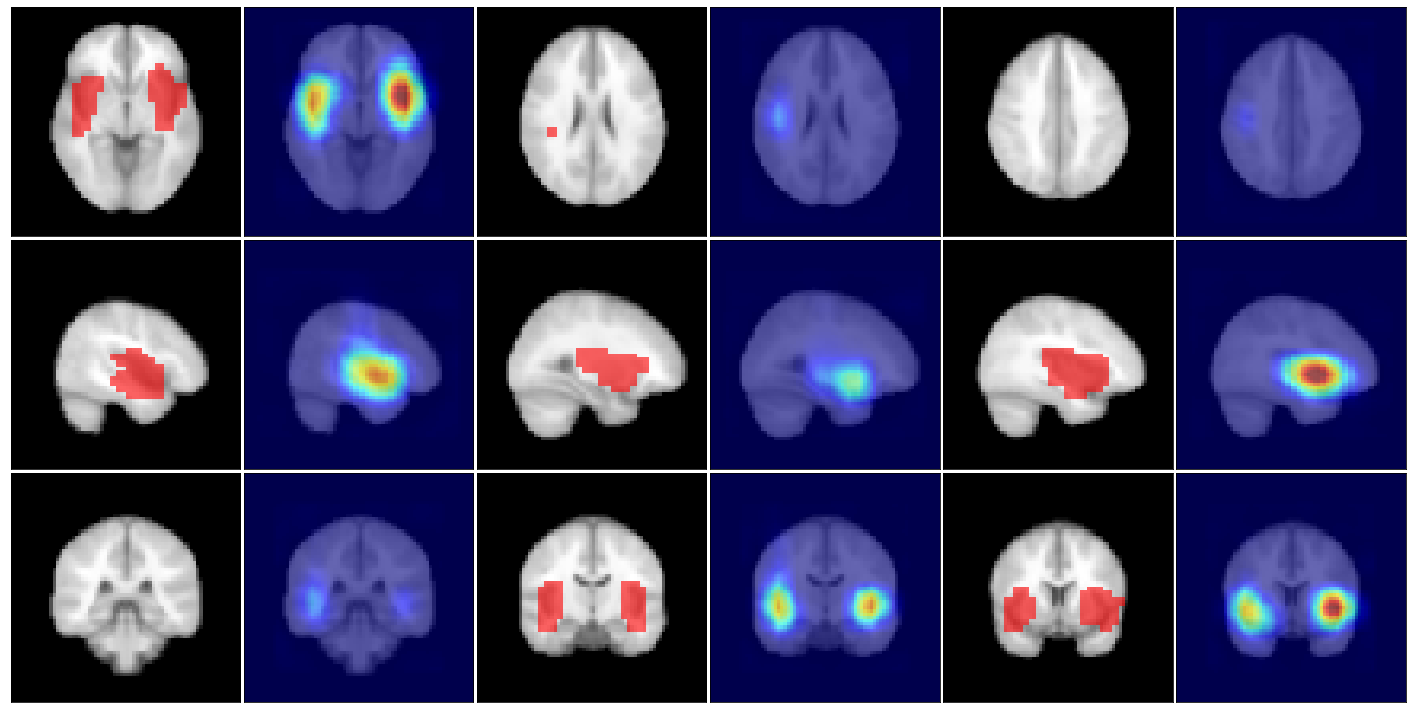

In [22]:
viz_recovered = resize(vae_mask, (60, 72, 60))

fig = plt.figure(figsize=(25., 25.))
grid = ImageGrid(fig, 111, 
                 nrows_ncols=(len(views), 6),
                 axes_pad=0.05,
                 share_all=True
                 )

grid[0].get_yaxis().set_ticks([])
grid[0].get_xaxis().set_ticks([])

acc = 0
for v_idx, v in enumerate(views):
    for slice_idx in range(slices_per_view):
        viz_functional_parcellation(viz_gt, grid[acc], v_idx, v[slice_idx],
                                    template_brain)
        acc += 1
        viz_functional_parcellation(viz_recovered, grid[acc], v_idx, v[slice_idx],
                                    template_brain, cmap='jet', vmin=vmin,
                                    vmax=vmax)
        acc += 1

plt.show()

In [12]:
# RUN SVR-LSM APPROXIMATION FOR DEBUGGING PURPOSES
from sklearn import svm

continuous = True

svm_data = np.reshape(train_data, [train_data.shape[0], train_data.shape[2]**3])

svr_labels = train_labels
if continuous:
    svr_labels = (train_labels - train_labels.mean())
    svr_labels = svr_labels / svr_labels.std()
svm_data = svm_data / (np.linalg.norm(svm_data, axis=-1, keepdims=True) + 1e-5)

if continuous:
    svm = svm.SVR(kernel='rbf', C=0.8)
else:
    svm = svm.SVC(kernel='rbf')
svm.fit(svm_data, svr_labels)

alphas = svm.dual_coef_

backprojection = alphas * np.transpose(svm.support_vectors_)
backprojection = np.sum(backprojection, axis=1)
svm_preds = np.reshape(backprojection, [train_data.shape[2], train_data.shape[2],
                                        train_data.shape[2]])
svm_preds.shape

(32, 32, 32)

In [13]:
# RUN VLSM APPROXIMATION FOR DEBUGGING PURPOSES

idxs_p = np.where(train_labels > 0)
idxs_n = np.where(train_labels == 0)
img_size = 32

fisher_preds = np.zeros((img_size, img_size, img_size))
for i in range(img_size):
    for j in range(img_size):
        for k in range(img_size):
            index_vox = train_data[:, 0, i, j, k]

            table = np.zeros((2, 2))
            table[0, 0] = np.sum(index_vox[idxs_n] == 0)
            table[0, 1] = np.sum(index_vox[idxs_n] > 0)
            table[1, 0] = np.sum(index_vox[idxs_p] == 0)
            table[1, 1] = np.sum(index_vox[idxs_p] > 0)

            p_value = scipy.stats.fisher_exact(table, 'greater')[-1]
            fisher_preds[i, j, k] = p_value

fisher_preds = - np.log(fisher_preds)
univar_preds = fisher_preds

In [14]:
def dice(im1, im2):
    im1 = np.asarray(im1).astype(np.bool)
    im2 = np.asarray(im2).astype(np.bool)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    intersection = np.logical_and(im1, im2)

    return 2. * intersection.sum() / (im1.sum() + im2.sum())

In [16]:
from monai.metrics import compute_hausdorff_distance, compute_average_surface_distance

'''
THIS IS JUST FOR DEBUGGING PURPOSES
FOR PROPER EVALUATION YOU'LL HAVE TO GET P-VALUES FOR VLSM AND SVR-LSM 
AND THEN USE FWER/FDR
'''

results = {'VDVAE-LDM': vae_mask, 'VLSM': univar_preds, 'SVR-LSM': svm_preds}

keys = ['VDVAE-LDM', 'VLSM', 'SVR-LSM']
thresholds = {}
for k in keys:
    thresholds[k] = {'dice': [0, 0], 'hausdorff': [1e10, 0], 'asd': [1e10, 0],
                    }

for k in results:
    results[k] = results[k] - results[k].min()
    results[k] = results[k] / (results[k].max())

# threshold_range = np.linspace(0.8, 0.98, num=20)
threshold_range = [0.9]

for thresh in threshold_range:
    for k in thresholds:
        t = np.quantile(results[k], thresh)
        bin_res = results[k] > t

        preds = np.expand_dims(np.expand_dims(results[k], axis=0), axis=0)
        bin_preds = np.expand_dims(np.expand_dims(bin_res, axis=0), axis=0)
        monai_gt = np.expand_dims(np.expand_dims(neural_substrate, axis=0), axis=0)
        
        dice_s = dice(bin_res, neural_substrate)
            
        if dice_s > thresholds[k]['dice'][0]:
            thresholds[k]['dice'][0] = round(dice_s, 2)
            if k == 'VDVAE-LDM':
                thresholds[k]['dice'][1] = best_threshold
            else:
                thresholds[k]['dice'][1] = thresh
            
            haus = compute_hausdorff_distance(bin_preds, monai_gt).numpy()[0][0]
            asd = compute_average_surface_distance(bin_preds, monai_gt,
                                                   symmetric=False).numpy()[0][0]
            
            thresholds[k]['hausdorff'][0] = round(haus, 2)
            thresholds[k]['hausdorff'][1] = thresh
            
            thresholds[k]['asd'][0] = round(asd, 2)
            thresholds[k]['asd'][1] = thresh
            
            
thresholds

{'VDVAE-LDM': {'dice': [0.3, 0.95],
  'hausdorff': [6.48, 0.9],
  'asd': [2.84, 0.9]},
 'VLSM': {'dice': [0.21, 0.9], 'hausdorff': [12.21, 0.9], 'asd': [4.81, 0.9]},
 'SVR-LSM': {'dice': [0.22, 0.9],
  'hausdorff': [12.85, 0.9],
  'asd': [4.53, 0.9]}}